# Introduction

---

As a business owner, customer reviews can be a valuable source of insight. Imagine being able to gradually monitor areas for improvement that increase customer satisfaction and highlight the best parts of the business for effective branding.

This project aims to segment user reviews into several topics for easier analysis.

The key components of our project include:
- **Review clustering**: to segment customer reviews into distinct clusters by representing the reviews as word vectors (combination of pre-trained [Transformer model](https://github.com/UKPLab/sentence-transformers) and self-train [Word2Vec model](https://radimrehurek.com/gensim/models/word2vec.html)),
- **Topic labeling**: to label review topics within each cluster using a large language model (LLM).

We also try implementing autoencoder to reduce the dimensionality of our word vectors.

**Keywords**: review clustering, nlp, word vector, embedding, llm, word2vec, pca, autoencoder.

## Dataset

The dataset for this project is [Google Local dataset](https://cseweb.ucsd.edu/~jmcauley/datasets.html#google_local) obtained from J. McAuley lab.

Originally, the dataset contains millions of business reviews from across the United States up to 2021. However, for the sake of simplicity and due to limited resources for this project, we only choose the data from one state and one business type: **tourist attractions in Hawaii** ✨.

In the end, we limit the dataset to 1000 locations with approximately 144k customer reviews.

In [1]:
!pip install -q en_core_web_sm transformers sentence-transformers openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00


In [130]:
from google.cloud import storage
from datetime import datetime
from openai import OpenAI

from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import io

In [3]:
def download_csv_from_gcs(bucket, file_name,
                          date_columns=None, col_names=None):
    """ A function to download dataset from GCS. """

    blob = bucket.blob(file_name)
    data = blob.download_as_text()
    df = pd.read_csv(io.StringIO(data),
                     parse_dates=date_columns,
                     usecols=col_names)
    return df

In [5]:
# Create a client GCS and get the specified bucket
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

In [6]:
# Download the dataset from GCS
reviews_df = download_csv_from_gcs(bucket, REVIEW_CSV)

In [7]:
reviews_df.head()

,business_id,user_id,time,text
0,0x7c006afc71065bd1:0x7a706dc72f4623ee,113728016128003691063,2021-08-31 04:41:40.565,We needed sun glasses before a boat ride and n...
1,0x7c006afc71065bd1:0x7a706dc72f4623ee,101488063088102775913,2021-08-24 07:48:29.263,Reasonable Prices Has quick food to go
2,0x7c006afc71065bd1:0x7a706dc72f4623ee,100536389119109882523,2021-07-25 00:58:57.672,Convenient liquor store with a little of every...
3,0x7c006afc71065bd1:0x7a706dc72f4623ee,110229694025406635705,2021-07-24 19:28:41.268,I love the spam musubis It's the bomb
4,0x7c006afc71065bd1:0x7a706dc72f4623ee,108697060494095206753,2021-04-08 21:00:29.786,Had a good selection of items at fairly decent...


In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144762 entries, 0 to 144761
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  144762 non-null  object
 1   user_id      144762 non-null  object
 2   time         144762 non-null  object
 3   text         144762 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB


In [105]:
# The dataset contains review from 2019-2021.
reviews_df["time"] = pd.to_datetime(reviews_df["time"])
reviews_df["time"].min().strftime("%Y-%m-%d"), reviews_df["time"].max().strftime("%Y-%m-%d")

('2019-01-01', '2021-08-31')

In [10]:
# Count the number of unique businesses and users
reviews_df[["business_id", "user_id"]].nunique()

,0
business_id,1035
user_id,72582


In [11]:
# Count the average number of reviews for each business
int(reviews_df.groupby("business_id")["text"].count().mean())

139

In [12]:
# Check the missing values
reviews_df.isna().sum()

,0
business_id,0
user_id,0
time,0
text,0


# Dataset Preparation

---



Before we begin word vector modeling and clustering, we preprocess our text dataset to prepare it for analysis. We apply general natural language processing (NLP) techniques, such as text cleaning, sentence segmentation, and tokenization. For this, we use Python library for NLP [Spacy](https://spacy.io/).

We noticed that the dataset treatment for the Transformer model is slightly different from that of the Word2Vec model, as stop words are not removed for the Transformer model in order to retain the full context.

In [13]:
from transformers import pipeline

import en_core_web_sm
import re

In [14]:
spacy_nlp = en_core_web_sm.load()

In [15]:
class ProcessDataset():
    """
      A class for preprocessing review data for training downstream models.
      Preprocessing includes:
        - Cleaning, splitting, and expanding sentences
        - Tokenizing and removing stop words from sentences
    """

    def __init__(self, spacy_nlp):

        self.nlp = spacy_nlp

    def _clean_text(self, text):
        """ Clean text from unnecessary tokens/substrings """

        # Remove emoji patterns
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # Emoticons
            "\U0001F300-\U0001F5FF"  # Symbols & pictographs
            "\U0001F680-\U0001F6FF"  # Transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
            "\U00002700-\U000027BF"  # Dingbats
            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            "\U00002600-\U000026FF"  # Misc symbols
            "\U00002B50-\U00002B59"  # Stars
            "]+", flags=re.UNICODE
        )
        text = emoji_pattern.sub(r"", text)

        # Extracts text between '(Translated by Google)' and '(Original)'.
        match = re.search(r"\(Translated by Google\)(.+?)  ", text)
        if match:
            text = match.group(1)

        return text

    def _split_and_tokenize(self, text):
        """
          Splits text into sentences using the spaCy model.
          Also tokenize and lemmatize.
        """

        sents = [sent for sent in self.nlp(text.lower()).sents if sent.text]

        full_sents = [sent.text for sent in sents]

        tokenized = [[ token.lemma_ for token in sent
                      if token.is_alpha
                        and not token.is_punct
                        and not token.is_stop ]
                     for sent in sents ]
        tokenized = [" ".join(sent) for sent in tokenized]
        # We do the above operation so that it can be exploded later

        return full_sents, tokenized

    def transform(self, dataset):
        """ The main text processing function. """

        data = dataset.copy()

        # Clean, split, and expand sentences
        data["text"] = data["text"].apply(self._clean_text)
        data.loc[:, ["processed_text", "tokens"]] = data["text"].apply(
            self._split_and_tokenize).apply(
                lambda x: pd.Series(x, index=["processed_text", "tokens"]))

        data = data.explode(["processed_text", "tokens"]).reset_index(drop=True)
        data = data[data["processed_text"].str.len() >= 10]

        # Tokenize sentence
        data["tokens"] = data["tokens"].apply(lambda x: x.split())
        data = data[data["tokens"].apply(lambda x: len(x) >= 2)]

        return data

In [16]:
data_processor = ProcessDataset(spacy_nlp)

In [17]:
processed_dataset = data_processor.transform(reviews_df)

In [18]:
# NOTE: we use `processed_text` as the transformer input and `tokens` for w2v
processed_dataset[["processed_text", "tokens"]].head()

,processed_text,tokens
0,we needed sun glasses before a boat ride and n...,"[need, sun, glass, boat, ride, need, quick, st..."
1,this little mom and pop convenience store had ...,"[little, mom, pop, convenience, store, need, i..."
2,we both got our sunglasses for a great price a...,"[get, sunglass, great, price, way, minute]"
3,reasonable prices has quick food to go,"[reasonable, price, quick, food]"
4,convenient liquor store with a little of every...,"[convenient, liquor, store, little, need]"


In [19]:
processed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303648 entries, 0 to 340745
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   business_id     303648 non-null  object        
 1   user_id         303648 non-null  object        
 2   time            303648 non-null  datetime64[ns]
 3   text            303648 non-null  object        
 4   processed_text  303648 non-null  object        
 5   tokens          303648 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 16.2+ MB


In [20]:
cols = ["processed_text", "tokens"]
processed_dataset[cols].to_parquet("processed_dataset_ckpt.parquet",
                                   index=False)
!gsutil cp "processed_dataset_ckpt.parquet" "gs://customer_review_hawaii/data/"

Copying file://processed_dataset_ckpt.parquet [Content-Type=application/octet-stream]...
/ [1 files][ 13.1 MiB/ 13.1 MiB]                                                
Operation completed over 1 objects/13.1 MiB.                                     


# Helper Functions

---



This section contains some helper functions, including review selection, cluster evaluation, cluster visualization, and cluster naming.

For cluster visualization, we use the Python library [Plotly](https://plotly.com/). For cluster naming, we use the [OpenAI API](https://platform.openai.com/docs/overview). The details can be found in the function implementations below.

In [109]:
# Helper functions for data selection, cluster evaluation, and visualization

class HDBSCANClustering(BaseEstimator, TransformerMixin):

    def __init__(self, n, apply_pca=False):
        self.model = HDBSCAN(metric="cosine",
                             min_cluster_size=n)
        self.labels_ = None

        # Optionally apply PCA to remove correlation
        self.apply_pca = apply_pca
        self.pca = PCA()

    def fit(self, X, y=None):
        """ Fit the cluster. """

        # Perform PCA transformation before clustering
        if self.apply_pca:
            X = self.pca.fit_transform(X)

        # Predict the label
        self.labels_ = self.model.fit_predict(X)
        return self

    def transform(self, X):
        """ Return the label """

        return self.labels_

def select_dataset(dataset, business_id, model_sentiment):
    """
      Select dataset based on the business_id on the past 6 months time period,
      also encode the sentiment using a pretrained model.
    """

    # Select data based on `business_id`
    data = dataset[dataset["business_id"] == business_id].copy()

    # Select reviews from the last six months
    data["time"] = pd.to_datetime(data["time"])
    time_limit = data["time"].max() - pd.DateOffset(months=6)
    data = data[data["time"] >= time_limit]

    # Extract the sentiment using a pretrained model
    data["sentiment"] = data["processed_text"].apply(lambda x: model_sentiment(x))
    data["sentiment"] = data["sentiment"].apply(lambda x: x[0]["label"])

    return data

def evaluate_cluster(X, y, name):
    """
        Evaluate clustering result using 3 evaluation metrics:
        1. `silhouette_score`: a metric used to calculate the goodness of fit
            of a clustering algorithm. Its value ranges from -1 to 1.
        2. `davies_bouldin_score`: the average similarity measure of each cluster
            with its most similar cluster. The minimum value is 0 for better model.
        3. `calinski_harabasz_score`: the ratio of the sum of between-cluster dispersion
            and of within-cluster dispersion. Higher index indicates separable clusters.
    """
    evaluation_scores = {}
    evaluation_scores["silhouette_score"] = [silhouette_score(X, y)]
    evaluation_scores["davies_bouldin_score"] = [davies_bouldin_score(X, y)]
    evaluation_scores["calinski_harabasz_score"] = [calinski_harabasz_score(X, y)]

    return pd.DataFrame(evaluation_scores,
                        index=[f"{name.title()} Reviews Clustering"]).T

def visualize_cluster(fig, df, x_column, y_column,
                      row=None, sentiment="positive"):

    """ Visualize the negative and positive review clusters """

    # Exclude the data labeled as "noise"
    n_noise = df[df[y_column] == "Other"][y_column].count()
    print(f"Outliers ratio ({sentiment}): {n_noise}/{len(df)}")
    df = df[df[y_column] != "Other"].copy()

    # Perform PCA transformation for visualization
    pca = PCA(n_components=2)
    df["pca"] = list(pca.fit_transform(np.vstack(df[x_column].values)))
    df[["pca_x", "pca_y"]] = pd.DataFrame(df["pca"].tolist(), index=df.index)

    # Encode the cluster label as category
    df[y_column] = df[y_column].astype("category")

    # Plot with px.scatter using the new PCA columns
    fig_px = px.scatter(df,
                        x="pca_x",
                        y="pca_y",
                        color=df[y_column],
                        hover_data={"processed_text": True, y_column: True,
                                    "pca_x": False, "pca_y": False},
                        color_discrete_sequence=px.colors.qualitative.Set1)

    # Add this plot to the subplot column
    for trace in fig_px.data:
        trace.legendgroup = row
        trace.showlegend = True
        fig.add_trace(trace, row=row, col=1)

client = OpenAI(
    api_key = api_key
)

def get_cluster_centroids(data, embedding_col, label_col, n):
    """ Get the top n-items closest to the cluster. """

    # Remove the items labeled as "noise", this will be labeled as "Other".
    data = data[data[label_col] > 0]

    # Get the unique cluster
    unique_clusters = np.unique(data[label_col])

    text_data = {}
    for id_ in unique_clusters:
        # Get the cluster data
        cluster_data = data[data[label_col] == id_]
        cluster_embeddings = np.array(cluster_data[embedding_col].tolist())

        # Calculate the centroid by taking the mean
        centroid = np.mean(cluster_embeddings, axis=0)

        # Compute the distance to the centroid for each item
        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

        # Get the top n-items
        closest_indices = np.argsort(distances)[:n]

        # Collect the text
        closest_texts = cluster_data.iloc[closest_indices]["processed_text"].tolist()
        text_data[id_] = closest_texts

    return text_data

def name_cluster(text_samples):
    """
      Name the cluster based on the review's content using OpenAI API.
    """

    prompt = f"""
        You are an expert in giving a descriptive topic to a given list of sentences.
        The sentences may have different topics, so choose the commonly shared one.
        Please return the topic as consice as possible, maximum in 3 words.

        There are maximum of 5 sentences as the input.
        The content of the sentences is limited to customer reviews for a tourist attraction sites.

        Here is an example with 3 setences:

        INPUT
        'Gorgeous place to visit, it can get crowded on holidays.'
        'Great hike and beautiful views.'
        'Awesome view.'
        ENDINPUT

        LABEL 'Scenic view'

        So here is the sentences:
        INPUT
        {text_samples}
        ENDINPUT

        LABEL ...
    """
    # Create a request
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content

# `SentenceTransformer` Model

---



Our goal in this project is to group customer reviews into clusters based on the topics of the reviews. To do this, the appropriate feature representation is word vectors.

To obtain word vectors from a sentence, we commonly use deep neural networks, either by training a model ourself or by using a pretrained one. Nowadays, several pretrained models are available for extracting word vectors.

The advantage of using a pretrained model is that its trained using advanced network on a large and diverse dataset. Though, the disavantage is that it may be less specific to the dataset. However, in general, these pretrained models perform well in most cases.

Hence, we use the [`SentenceTransformer` model](https://github.com/UKPLab/sentence-transformers), to be specific, we use the `all-MiniLM-L6-v2` model.

## Clustering

In [31]:
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

In [ ]:
model_llm = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
model_sentiment = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")

In [35]:
class LLMEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, model):
        # Load the Transformer model
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """ Transform the data using the transformer model. """

        wv = X.apply(lambda x: self.model.encode(x, normalize_embeddings=True))
        return wv

In [36]:
llm_encoder = LLMEncoder(model_llm)

In [37]:
business_id = np.random.choice(processed_dataset["business_id"])

In [110]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(processed_dataset, business_id, model_sentiment)

# Get the word vector from the pretrained transformer model
selected_data["llm"] = llm_encoder.transform(selected_data["processed_text"])

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["llm"].values)
    n = 3 if (len(X) > 25) else 2

    # Clustering
    clust = HDBSCANClustering(n, apply_pca=True)
    X["llm_label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["llm_label"], sentiment))

    # Clusters' topic extraction
    cluster_text = get_cluster_centroids(X, "llm", "llm_label", n)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    X["llm_label"] = X["llm_label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "llm", "llm_label",
                      row=i, sentiment=sentiment)

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using LLM Word Vector (384-dimension)",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=300
    )
)
fig.show()

Outliers ratio (positive): 68/118
Outliers ratio (negative): 3/10


In [111]:
# Evaluation
llm_eval = pd.concat(evaluation, axis=1)
llm_eval

,Positive Reviews Clustering,Negative Reviews Clustering
silhouette_score,0.018232,0.067295
davies_bouldin_score,2.282446,1.322658
calinski_harabasz_score,4.812645,1.721750


# Word2Vec Model

---



In the previous section, we saw that clustering with word vectors provides some separation, but the results are still insufficient.

A common approach to improve the fit of a pretrained model to a specific dataset is fine-tuning. However, this requires large computational resources.

Alternatively, we can train a custom model and then **concatenate** its word vectors with those from the pretrained model before clustering. For this project, we chose this approach. We trained a custom skip-gram Word2Vec model on our review dataset to create word vectors specific to our data.

## Training

In [53]:
class W2VEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, model=None, norm=True):
        # Use any existing w2v model
        self.model = model
        self.norm = norm

    def fit(self, X, y=None):
        """ Train the w2v model. """

        # If not pretrained model isn't provided, train a new model
        if not self.model:
            self.model = Word2Vec(X, vector_size=384,
                                  window=2, min_count=1,
                                  compute_loss=True, epochs=50,
                                  alpha=0.001, min_alpha=0.0001)

        print("Finished training!")
        print(f"Latest training loss (cumulative): {self.model.get_latest_training_loss()}")

        return self

    def transform(self, X):
        """ Transform the data using the learned w2v model. """

        wv = X.apply(lambda tokens: [self.model.wv.get_vector(token, norm=True)
                                    for token in tokens if token in self.model.wv])

        wv = wv.apply(lambda v: np.array(v).mean(axis=0))
        return wv

In [54]:
# Train the Word2Vec model
w2v_encoder = W2VEncoder()
w2v_encoder.fit(processed_dataset["tokens"])

Finished training!
Latest training loss (cumulative): 35726564.0


W2VEncoder(model=<gensim.models.word2vec.Word2Vec object at 0x7ff18ac92710>)

In [55]:
# Save model for future access
# w2v_encoder.model.save(f"model_w2v")

## Clustering

In [112]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(processed_dataset, business_id, model_sentiment)

# Get the word vector from the trained Word2Vec model
selected_data["w2v"] = w2v_encoder.transform(selected_data["tokens"])

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["w2v"].values)
    n = 3 if (len(X) > 25) else 2

    # Clustering
    clust = HDBSCANClustering(n, apply_pca=True)
    X["w2v_label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["w2v_label"], sentiment))

    # Cluster topic extraction
    cluster_text = get_cluster_centroids(X, "w2v", "w2v_label", n)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    X["w2v_label"] = X["w2v_label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "w2v", "w2v_label",
                      row=i, sentiment=sentiment)

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using W2V Word Vector (384-dimension)",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=300
    )
)
fig.show()

Outliers ratio (positive): 66/118
Outliers ratio (negative): 3/10


In [113]:
# Evaluation
w2v_eval = pd.concat(evaluation, axis=1)
w2v_eval

,Positive Reviews Clustering,Negative Reviews Clustering
silhouette_score,0.019144,0.134857
davies_bouldin_score,2.041781,1.394217
calinski_harabasz_score,7.212768,2.409170


# Concatenated Word Vectors

---



In this section, we **concatenate** the word vectors from Word2Vec with the one generated by `SentenceTransformers`.

We also look for a way to make the vector concatenation more effective.

In [114]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(processed_dataset, business_id, model_sentiment)

# Get the word vector from the trained Word2Vec model
selected_data["w2v"] = w2v_encoder.transform(selected_data["tokens"])
selected_data["llm"] = llm_encoder.transform(selected_data["processed_text"])
selected_data["mix"] = selected_data[["w2v", "llm"]].apply(
                          lambda x: np.hstack([x["w2v"], x["llm"]]), axis=1
                      )

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["mix"].values)
    n = 3 if (len(X) > 25) else 2

    # Clustering
    clust = HDBSCANClustering(n, apply_pca=True)
    X["mix_label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["mix_label"], sentiment))

    # Cluster topic extraction
    cluster_text = get_cluster_centroids(X, "mix", "mix_label", n)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    X["mix_label"] = X["mix_label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "mix", "mix_label",
                      row=i, sentiment=sentiment)

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using Concatenated Word Vector (768-dimension)",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=300
    )
)
fig.show()

Outliers ratio (positive): 46/118
Outliers ratio (negative): 2/10


In [115]:
# Evaluation
mix_eval = pd.concat(evaluation, axis=1)
mix_eval

,Positive Reviews Clustering,Negative Reviews Clustering
silhouette_score,0.018616,0.093173
davies_bouldin_score,2.480226,1.593230
calinski_harabasz_score,4.779274,1.942481


The result of vector concatenation is slightly better than the LLM model but still worse than the self-trained Word2Vec model. The most significant difference is the number of reviews that are considered as "noise" by the HDBSCAN clustering algorithm (cluster -1).

As mentioned in [here](https://stats.stackexchange.com/questions/315272/merging-two-word-embedding-models), we decided to train an autoencoder model to **reduce the dimensionality** of our combined word vectors to see if we can improve the result by obtaining only the latent variables from the concatenated word vectors.

Before training the autoencoder, we apply PCA to determine the optimal dimensionality required to retain sufficient information from the embeddings.

## Determine the size of the latent vars

We estimate the size of the latent variables using PCA. However, due to the size of our dataset, we only use 10% of it for this analysis.

We found that a 365-dimensions vector is sufficient to capture 99% of the total variance.

In [67]:
# Take 10% sample from the dataset
sample_10p = processed_dataset.sample(int(0.1 * len(processed_dataset)))

# Pre-calculate the word vectors, then concatenate
sample_10p["w2v"] = w2v_encoder.transform(sample_10p["tokens"])
sample_10p["llm"] = llm_encoder.transform(sample_10p["processed_text"])
sample_10p["mix"] = sample_10p[["w2v", "llm"]].apply(
                          lambda x: np.hstack([x["w2v"], x["llm"]]), axis=1
                      )

In [68]:
# Initialize PCA
pca = PCA()
X = np.vstack(sample_10p["mix"].values)
pca.fit(X)

# Calculate the cumulative variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

# Find 'n_component' where cumulative explained variance = threshold
threshold = 0.99
n = np.argmax(cumulative_var >= threshold) + 1
print(n)

362


## Autoencoder dataset preparation

We implement the autoencoder using PyTorch, so we need to wrap the dataset using the PyTorch `Dataset` class.

In [69]:
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

In [70]:
# Turn the DataFrame to Pytorch Dataset

class AutoEncoderDataset(Dataset):
    def __init__(self, dataset, w2v_encoder, llm_encoder, source="mix"):
        self.data = dataset.copy()

        self.w2v_encoder = w2v_encoder
        self.llm_encoder = llm_encoder

        assert source in ["w2v", "llm", "mix"]
        self.source = source

    def get_feature_dim(self):
        """ Return the feature (word vector) dimension """

        return len(self.__getitem__(0))

    def __len__(self):
        """ Return the length of the dataset """

        return len(self.data)

    def __getitem__(self, idx):
        """ Return row data """

        data = self.data.iloc[idx, :].copy()

        data["w2v"] = self.w2v_encoder.transform(data[["tokens"]]).iloc[0]
        data["llm"] = self.llm_encoder.transform(data[["processed_text"]]).iloc[0]
        data["mix"] = np.hstack(data[["w2v", "llm"]].values)

        # Return the dataset according to wordvecs' source
        return torch.tensor(data[self.source], dtype=torch.float32)

In [116]:
dataset_ae = AutoEncoderDataset(processed_dataset, w2v_encoder, llm_encoder,
                                source="mix")

## Autoencoder training

In [72]:
class Autoencoder(BaseEstimator, TransformerMixin, nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim,
                 lr=1e-4, epochs=1, batch_size=256):

        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        # Define the Encoder layer
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Define the Decoder layer
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, X):
        """ Forward pass to get the reconstructed input """
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, X):
        """ Get the latent variables """
        return self.encoder(X)

    def fit(self, X):
        """ Train the autoencoder """

        dataloader = DataLoader(X, batch_size=self.batch_size, shuffle=True)

        # Define optimizer and loss function
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=self.lr)

        # Training loop
        self.train()
        for epoch in range(self.epochs):
            losses = 0
            with tqdm(total=len(dataloader),
                      desc=f"Epoch {epoch + 1}", unit="batch") as pbar:

                for X_batch in dataloader:
                    # Forward pass
                    reconstructed_X = self.forward(X_batch)
                    loss = criterion(reconstructed_X, X_batch)

                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    losses += loss.item()

                    pbar.set_postfix({'Loss': loss.item()})
                    pbar.update(1)

                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {(losses/len(dataloader)):.3f}")

        return self

    def transform(self, X):
        """ Extract latent variables in a batch """

        self.eval()

        encoded = []
        dataloader = DataLoader(X, batch_size=self.batch_size, shuffle=False)
        for X_batch in dataloader:
            with torch.no_grad():
                encoded.append(self.encode(X_batch).cpu().numpy())

        return np.vstack(encoded)

In [117]:
# Define the hyperparameters for autoencoder training
ae_hyperparams = {
    "input_dim": dataset_ae.get_feature_dim(),
    "hidden_dim": 1024,
    "latent_dim": 365,
    "lr": 1e-5,
    "epochs": 1,
    "batch_size": 1024
}

In [118]:
# Train autoencoder
model_ae = Autoencoder(**ae_hyperparams)
wv_ae = model_ae.fit(dataset_ae)

Epoch 1: 100%|██████████| 297/297 [1:38:22<00:00, 19.87s/batch, Loss=0.00115]

Epoch 1/1, Loss: 0.001


In [119]:
# Save model for future access
# torch.save(model_ae.state_dict(), f"autoencoder")

## Clustering

In [120]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(processed_dataset, business_id, model_sentiment)

# Get the word vector from the trained autoencoder
selected_data_ae = AutoEncoderDataset(selected_data, w2v_encoder, llm_encoder,
                                      source="mix")
selected_data["w2v_ae"] = list(model_ae.transform(selected_data_ae))

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["w2v_ae"].values)
    n = 3 if (len(X) > 25) else 2

    # Clustering
    clust = HDBSCANClustering(n, apply_pca=True)
    X["w2v_ae_label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["w2v_ae_label"], sentiment))

    # Cluster topic extraction
    cluster_text = get_cluster_centroids(X, "w2v_ae", "w2v_ae_label", n)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    X["w2v_ae_label"] = X["w2v_ae_label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "w2v_ae", "w2v_ae_label",
                      row=i, sentiment=sentiment)

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using Compressed Word Vector (365-dimension)",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=300
    )
)
fig.show()

Outliers ratio (positive): 72/118
Outliers ratio (negative): 3/10


In [123]:
# Evaluation
ae_eval = pd.concat(evaluation, axis=1)
ae_eval

,Positive Reviews Clustering,Negative Reviews Clustering
silhouette_score,-0.043716,0.144295
davies_bouldin_score,1.897501,1.300463
calinski_harabasz_score,6.559215,2.757287


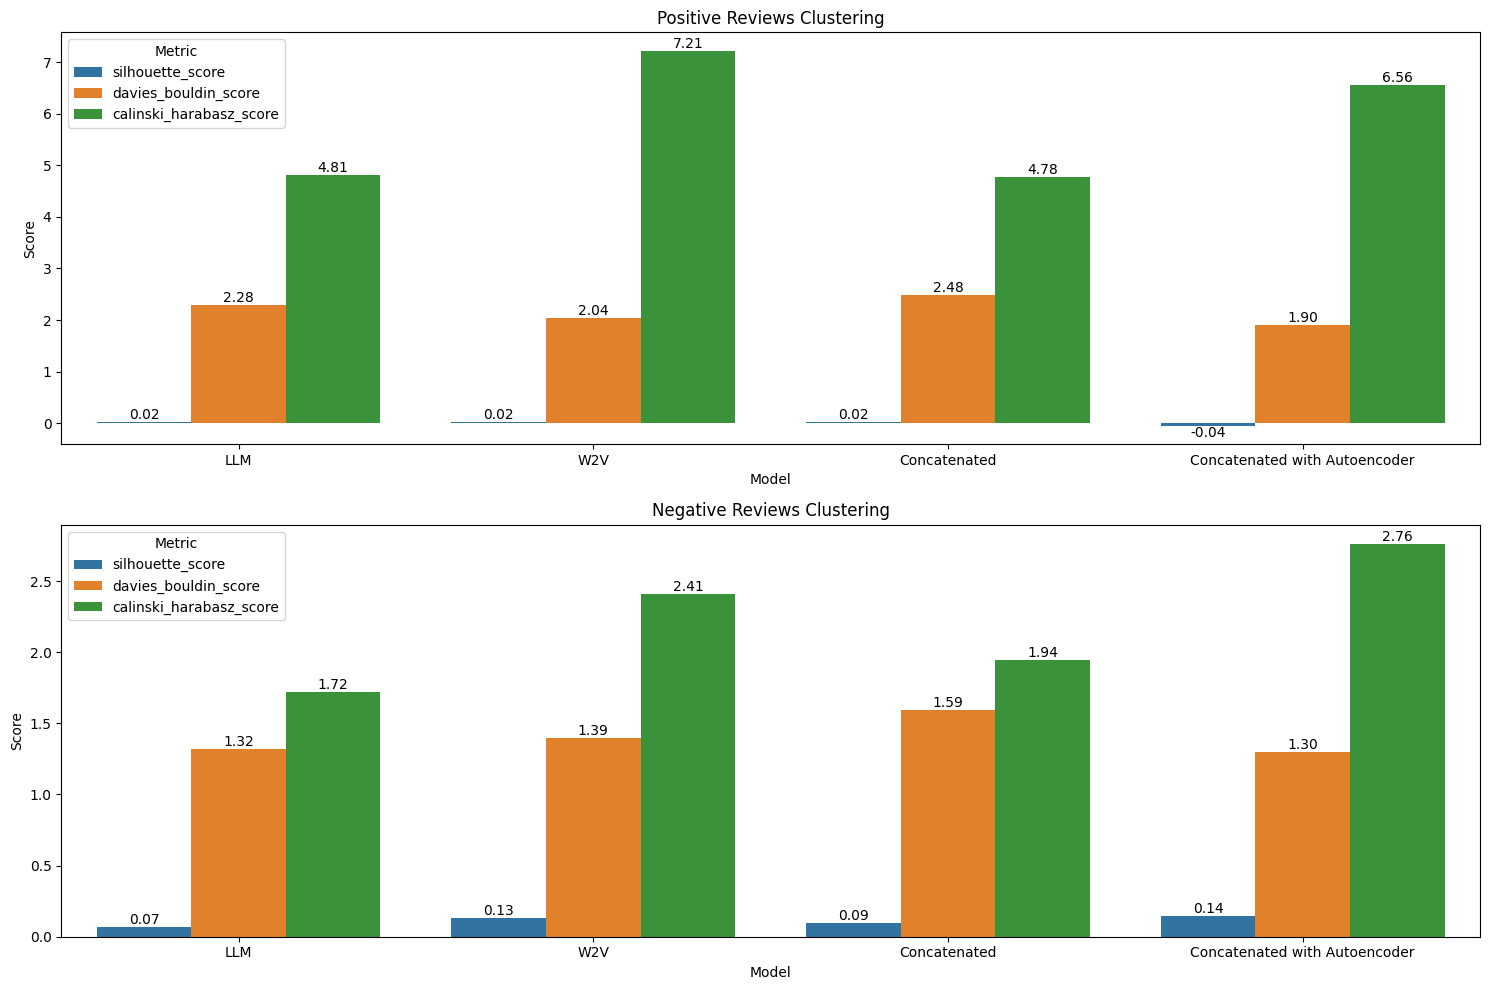

In [142]:
evaluations = [llm_eval, w2v_eval, mix_eval, ae_eval]
name = ["LLM", "W2V", "Concatenated", "Concatenated with Autoencoder"]

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for row, sentiment in enumerate(["Positive", "Negative"]):
    dataset = [[name[i], j, score]
                  for i, eval in enumerate(evaluations)
                  for j, score in eval[f"{sentiment} Reviews Clustering"].items()
              ]
    dataset = pd.DataFrame(dataset, columns=["Model", "Metric", "Score"])
    sns.barplot(dataset, x="Model", y="Score", hue="Metric", ax=ax[row])

    for container in ax[row].containers:
        ax[row].bar_label(container, fmt="%.2f", label_type="edge")

    ax[row].set_title(f"{sentiment} Reviews Clustering")

fig.tight_layout()
plt.show()

# Summary

---



In this notebook, we compare several word vectors from different sources for our customer review clustering.

The evaluation results suggest that the W2V or the Concatenated with Autoencoder model performs well according to the metrics we used.

Of course, an extensive evaluation with a larger test dataset is necessary for a more objective comparison. A comparison of execution time is also required, which will be part of future work for this project.